In [22]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from matplotlib  import rcParams

import warnings
warnings.filterwarnings("ignore")
 
# prophet by Facebook
from fbprophet import Prophet

In [ ]:
!pip install prophet


In [5]:
%matplotlib inline
rcParams["figure.figsize"] = 16,6
c = '#386B7F'


In [15]:
# !pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muluworkshegaw","key":"08fc7f3f34ec9dbfa1b3be5cd70992d6"}'}

In [16]:
 !mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c rossmann-store-sales


In [20]:
from zipfile import ZipFile
file_name = "test.csv.zip"


with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")

Done


In [21]:
# upload the data sets
store_data = pd.read_csv("store.csv")
sample_submission_data = pd.read_csv("test.csv")
test_data = pd.read_csv("test.csv")
train_data =pd.read_csv("train.csv",parse_dates = True)


# Task 1

#### Glance the data

In [ ]:
#glance the data
print("shape of the  store data: ",store_data.shape)
print("\n")
print(store_data.info())
store_data.head()

In [25]:
print("shape of the  train data: ",train_data.shape)
print("\n")
print(train_data.nunique())
train_data.head()
train_data['Date']
train_data.dtypes

shape of the  train data:  (1017209, 9)


Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64


Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [ ]:
print("shape of the  test data: ",test_data.shape)
print("\n")
print(test_data.nunique())
test_data.head()

Short description:
- **Sales**: the turnover for any given day (target variable).
- **Customers**: the number of customers on a given day.
- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some -stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Data cleaning

In [70]:
#data extraction
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['WeekOfYear'] = train_data['Date'].dt.weekofyear
train_data['weekDay'] = train_data["Date"].dt.weekday
train_data['weekEnds'] = train_data["Date"].dt.weekday >=5


# adding new variable
train_data['SalePerCustomer'] = train_data['Sales']/train_data['Customers']
train_data['SalePerCustomer'].describe()

count    844338.000000
mean          9.493641
std           2.197448
min           2.749075
25%           7.895571
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [76]:
train_data[train_data['StateHoliday'] != '0']

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,week day,weekDay,weekEnds
63559,5,4,2015-06-04,5807,625,1,1,a,0,2015,6,4,23,9.291200,3,3,False
63560,6,4,2015-06-04,5749,614,1,1,a,0,2015,6,4,23,9.363192,3,3,False
63609,55,4,2015-06-04,5984,702,1,1,a,0,2015,6,4,23,8.524217,3,3,False
63611,57,4,2015-06-04,9301,870,1,1,a,0,2015,6,4,23,10.690805,3,3,False
63614,60,4,2015-06-04,10399,850,1,1,a,0,2015,6,4,23,12.234118,3,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,2013,1,1,1,5.962898,1,1,False
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,2013,1,1,1,4.528818,1,1,False
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,2013,1,1,1,4.034455,1,1,False
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,2013,1,1,1,4.322425,1,1,False


In [ ]:
train_d = train_data #for later

missing_data = pd.DataFrame(train_data.isna().sum(),columns=(['Missing Train']))
missing_data["missing_test"] = test_data.isnull().sum() # before deling missing values
missing_data

- as shown in the table the train data has no a missing value and the test data has a missing value for open variable , we impute it.

In [29]:
# impute the missing value in test data
test_data['Open'].fillna(test_data['Open'].mode, inplace = True)
test_data.isnull().values.any()


False

In [ ]:
# closed stores
train_data[(train_data.Open == 0) & (train_data.Sales == 0)].count()

- There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

In [31]:
 
print(train_data.shape)
closed_stores = train_data[(train_data['Open'] == 0) & (train_data['Sales'] == 0)].index
train_data.drop(closed_stores,inplace = True)
print(train_data.shape)


(1017209, 14)
(844392, 14)


In [32]:
open_no_sale = train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)].index
train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)]['Date'].nunique()
  


49

- There are opened store with no sales on working days. There're only 49 days in the data, so we can assume that there were external factors involved,

In [ ]:
train_data.drop(open_no_sale,inplace = True)
train_data.shape

In [ ]:
#exceptional stores that has open during holidays

store_exc = train_data[(train_data["StateHoliday"] != "o") 
        & (train_data["Sales"] != 0)]["Store"].nunique()
print("exceptional stores that has opened during state holidays:",store_exc)


In [ ]:
store_data.isnull().sum()

- We have few variables with missing values that we need to deal with. Let's start with the CompetitionDistance.

In [ ]:
# missing values in CompetitionDistance
store_data[pd.isnull(store_data.CompetitionDistance)]

- No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average)

In [37]:
# fill NaN with a median value (skewed distribuion)
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace = True)

In [38]:
# replace NA's by 0
store_data.fillna(0, inplace = True)


In [ ]:
print("Joining train set with an additional store information.")

train_store = pd.merge(train_data, store_data, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

- In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [ ]:
train_store.groupby('StoreType')['Sales'].describe()


- StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [ ]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()


- Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

## Overview

####  Check for seasonality in training data set?

In [42]:
#check seasonality for the give store
def seasonality(store):
    sale = train_data[train_data.Store == store]
    sale = sale.sort_values(by = "Date",ascending= False)
    sns.lineplot(x = sale["Date"], y = sale["Sales"], color= c )

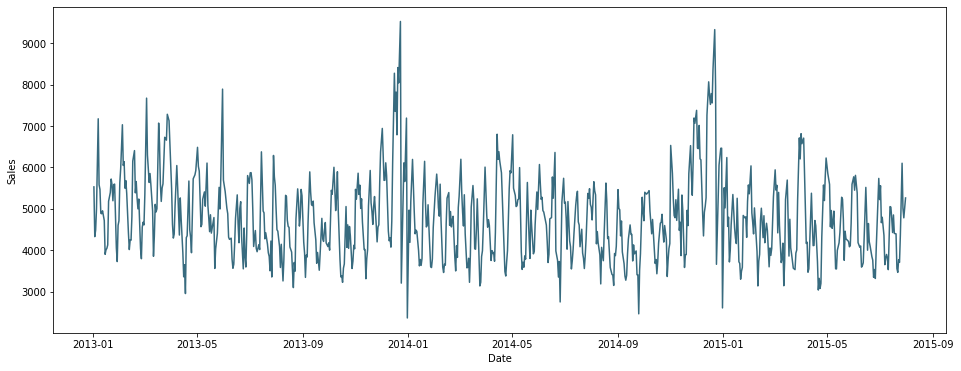

In [43]:
seasonality(1)

NB:
- christmass = around the last month(12-26)
- easter = around the the fourth month(04-06)
- public holiday = around the sixth month(06-04)

The slales around the holidays are  high 

####  Check & compare sales behavior before, during and after holidays 

In [44]:
pre_holiday = train_data[(train_data["Date"]> '2013-12-09') & (train_data["Date"]< '2013-12-20')  ]

during_holiday=train_data[(train_data["Date"]> '2013-12-22') & (train_data["Date"]< '2013-12-29')  ]

post_holiday = train_data[(train_data["Date"]> '2014-01-01') & (train_data["Date"]< '2014-01-15')  ]

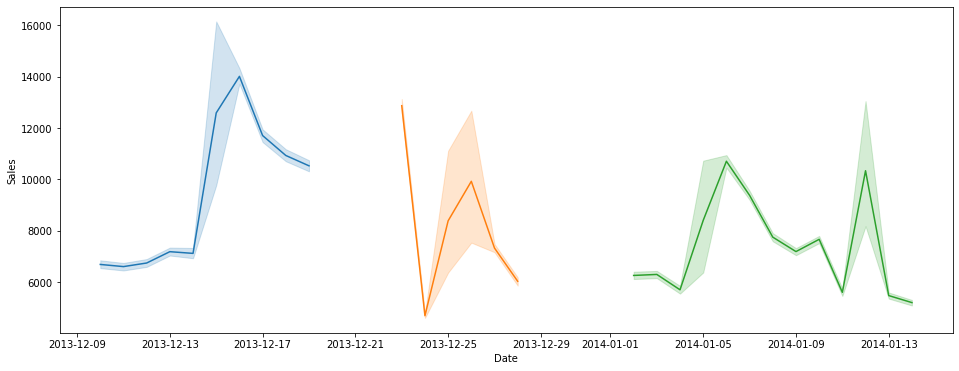

In [45]:
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Sales"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday.Sales )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday.Sales )

#### Find out any seasonal (Christmas, Easter etc) purchase behaviours,


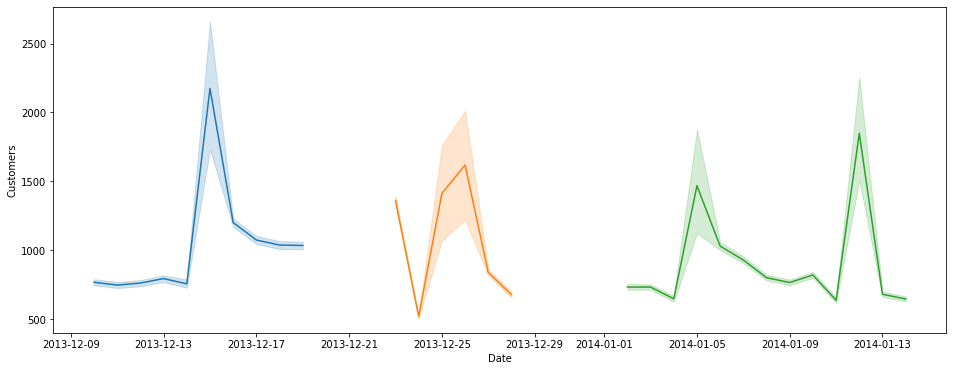

In [46]:
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Customers"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday.Customers )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday.Customers )

- As shown in the figure, the purchase before the holiday is high and during the holiday is relatively before the holiday it starts decrease and the day after the holiday is small.

####  What can you say about the correlation between sales and number of customers?

In [ ]:
corr_matrix = train_store.drop('Open', axis = 1).corr()

mask = np.zeros_like(corr_matrix, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr_matrix,annot=True,mask=mask, linewidths=.5,ax = ax, cmap = "BuPu")


- As shown in the figure , the more purpeled square is the more related data, so which is **sales and customers**

#### How does promo affect sales? Are the promos attracting more customers? 

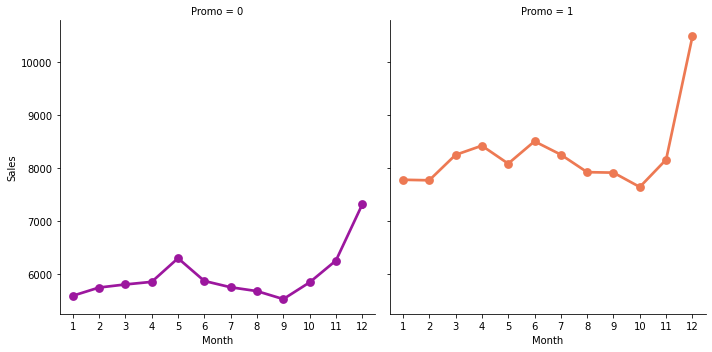

In [48]:
#promo and sales
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', # sales per promo  in cols
               palette = 'plasma',
               hue = 'Promo',
              
               color = c) 

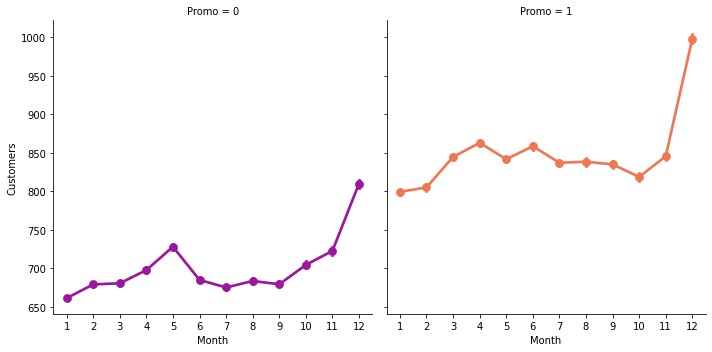

In [49]:
#promo and customers

sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'Promo', # sales per promo  in cols
               palette = 'plasma',
               hue = 'Promo',
              
               color = c) 

**Could the promos be deployed in more effective ways? Which stores should promos be deployed in?**

In [50]:
#promo and stores


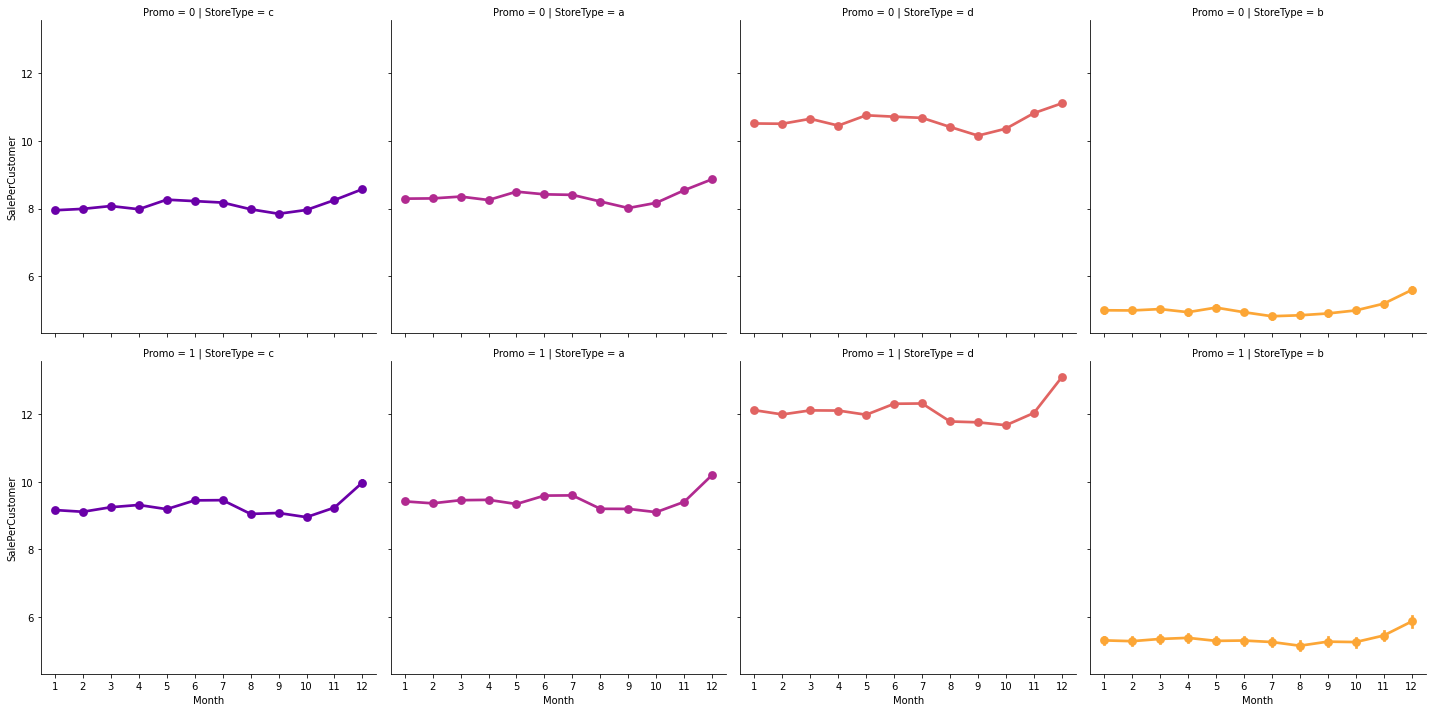

In [51]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

- Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period

So the store type need more effective promotion, even if the number of customers increase the rate of the things they buy(sales) doesn't increase
 - they may can share the experiance of the store type D

**Trends of customer behavior during store open and closing times**

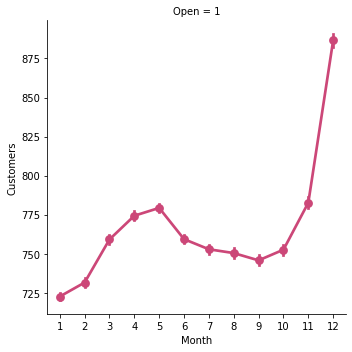

In [52]:
sns.factorplot(data = train_d, x = 'Month', y = "Customers", 
               col = 'Open', # sales per promo  in cols
               palette = 'plasma',
               hue = 'Open',
              
               color = c) 

####  Which stores are opened on all weekdays? How does that affect their sales on weekends? 

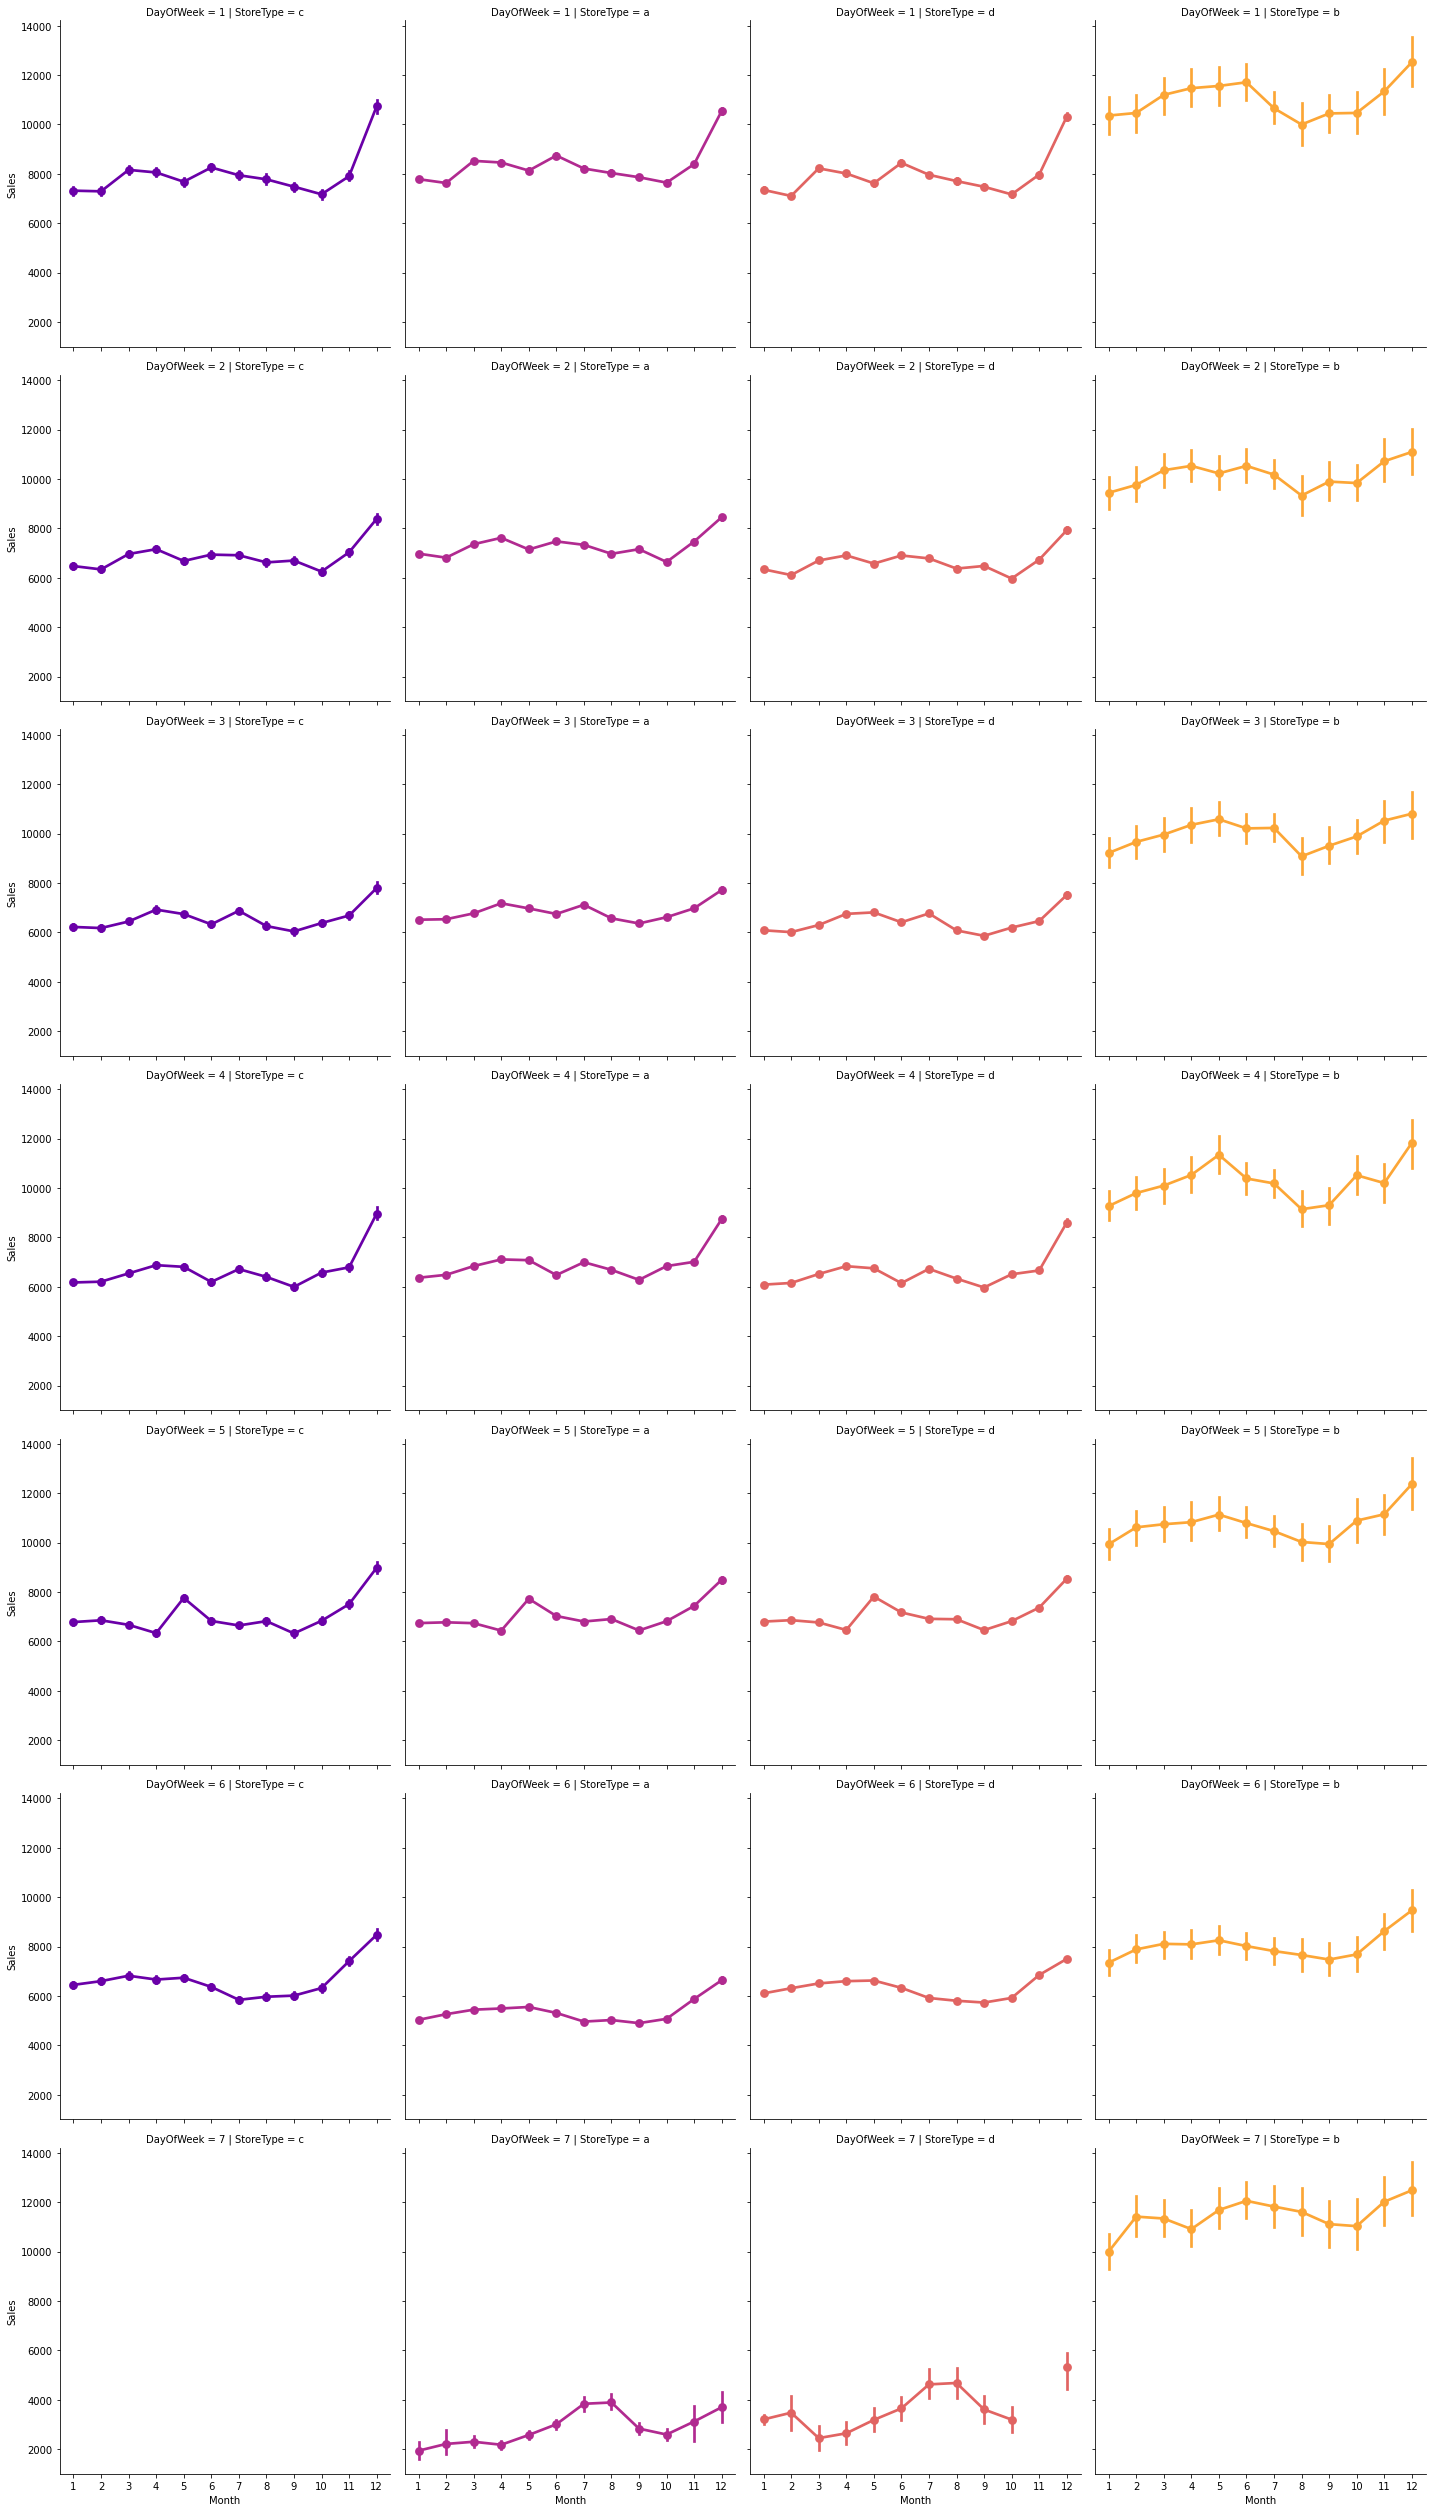

In [53]:
#customers trends
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'DayOfWeek', # per day of week in the store in rows
               color = c) 

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

#### Check how the assortment type affects sales 

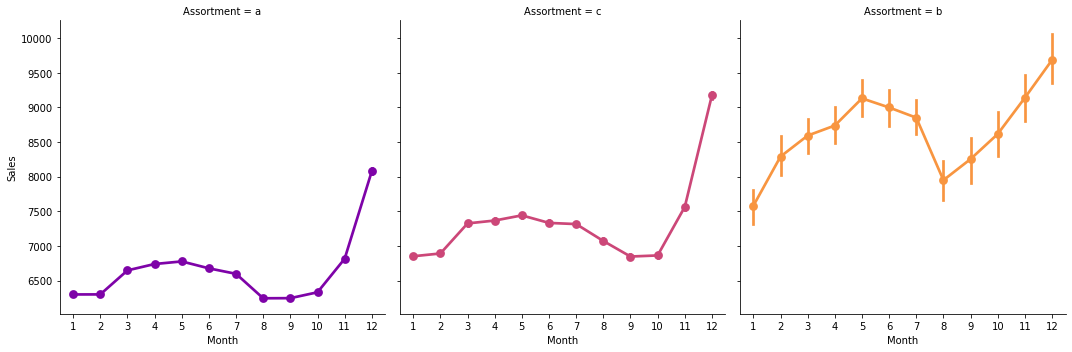

In [54]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Assortment',
               palette = 'plasma',
               hue = 'Assortment',
               color = c) 

- Assortment type b has high sale, the trend that ass-b use is better than others.

**How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?**

In [55]:
comp_store = train_store.groupby("Store").agg({'CompetitionDistance':'max','Sales':'sum'})

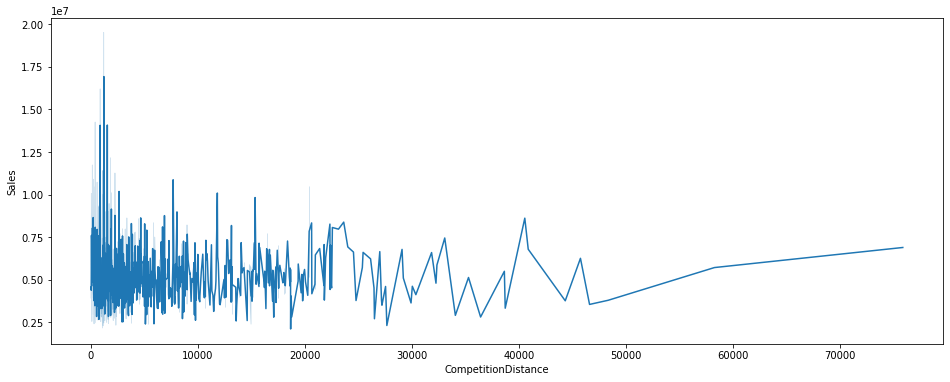

In [56]:
sns.lineplot(x = 'CompetitionDistance',y = "Sales",
             data = comp_store)

- As shown in the figure the more the store found in same place , they have more sales.
- which means, there are higher sales where other stores are found within 10km, otherwise it's usually not in city

**How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on has values for competitor distance**

In [57]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)

train_store.fillna(0, inplace = True)

col = ['StoreType', 'Sales','Customers', 'CompetitionOpen']
comp_open = train_store[col]
comp_open.head()

,StoreType,Sales,Customers,CompetitionOpen
0,c,5263,555,82.0
1,c,5020,546,82.0
2,c,4782,523,82.0
3,c,5011,560,82.0
4,c,6102,612,82.0


# Task 2

## Preprocessing

In [ ]:
#Dealing with the outlier
def deal_outliers(data,columns):
    data[columns].plot(kind = 'box')
    print("before dealing with the ouliers the shape of the data",
          data.shape)
    for col in columns:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)
        data = data[data[col]>lower_bound]
        data = data[data[col]<upper_bound]
    data[columns].plot(kind = 'box')
    print("after removing the outliers",data.shape)

before dealing with the ouliers the shape of the data (844338, 14)
after removing the outliers (788771, 14)


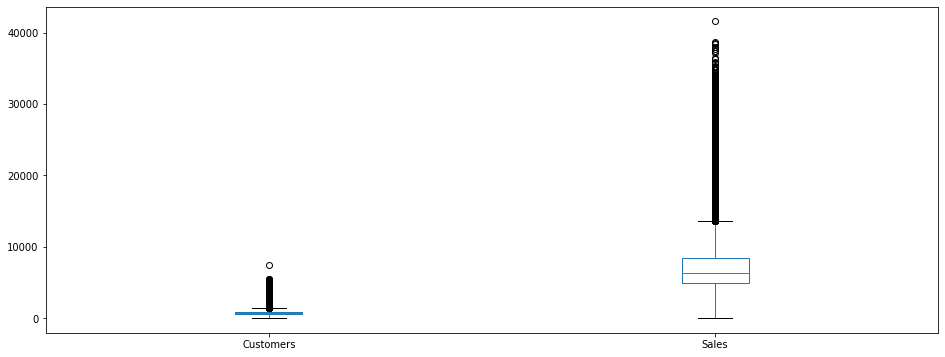

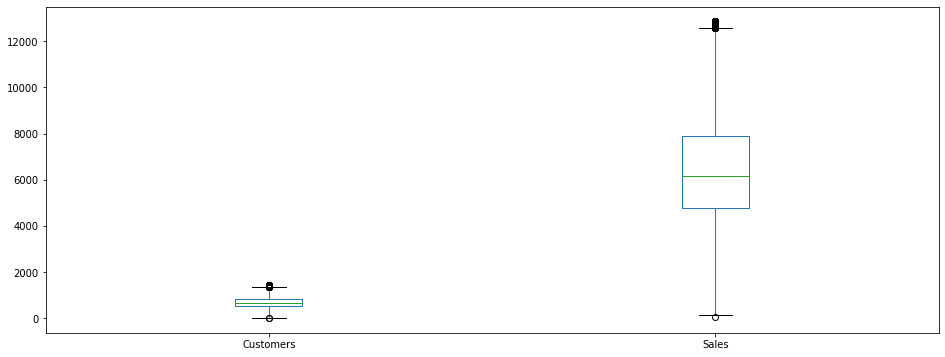

In [ ]:
# deal_outliers(train_data, ['Customers','Sales'])

In [77]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,week day,weekDay,weekEnds
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883,4,4,False
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400,4,4,False
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675,4,4,False
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457,4,4,False
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118,4,4,False


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


Why use **Random Forest** Algorithm in machine learning.

- Random forest algorithm can be used for both classifications and regression task.
- It provides higher accuracy.
- Random forest classifier will handle the missing values and maintain the accuracy of a large proportion of data.
- If there are more trees, it won’t allow overfitting trees in the model.
- It has the power to handle a large data set with higher dimensionality

- **Stock Market:** Machine learning also plays role in the stock market analysis. When you want to know the behavior of the stock market, with the help of Random forest algorithm, the behavior of the stock market can be analyzed. Also, it can show the expected loss or profit which can be produced while purchasing a particular stock.

In [78]:
df = pd.read_csv("train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [79]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


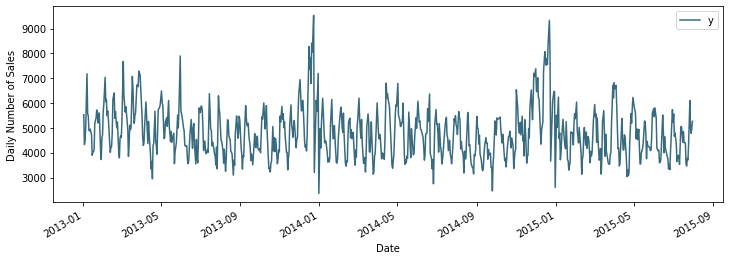

In [80]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()


Modeling Holidays

In [81]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [82]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11
